*Теоретический материал:* https://youtu.be/jpEtBjUUj6U

# Классификация музыкальных жанров

*Разбор данного раздела:* https://youtu.be/8uBvaTGCR5I?t=7

In [ ]:
#Подключаем библиотеки
from google.colab import files #Загрузка файлов
from tensorflow.keras.utils import to_categorical #Для представления в формате one_hot_encoding
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np #Numpy массивы
import matplotlib.pyplot as plt #Отображение графиков

from tensorflow.keras.optimizers import Adam, RMSprop #Подключаем оптимизаторы
from tensorflow.keras.models import Sequential, Model #Модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Базовые слои
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных

In [ ]:
from google.colab import drive #подключаем библиотеку для работы с google диском
drive.mount('/content/drive') #монтируем google диск
#Базу для ноутбука можно скачать по ссылке
#http://marsyas.info/downloads/datasets.html

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/Базы/genres.zip' #распаковываем архив на google диске на локальный диск google colaboratory 

genres = os.listdir('genres') # получаем список папок в распакованной папке

#Проверяем выгруженные папки
!ls genres 
#И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
#Функция параметризации аудио
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по умолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты (по умолчанию 20)
  
  rmse = np.mean(librosa.feature.rms(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #среднее спектральныго центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #среднее частота пересечения нуля звукового временного ряда
  
  
  #Добавляем все параметры в один список
  out = [] # создаем пустой список
  out.append(rmse) #  добавляем среднеквадратичную амплитуду
  out.append(spec_cent) #добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля
  
  #добавляем среднее всех Мел спектральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  #добавляем среднее всех Частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список размерностью (37,)
  return out

In [ ]:
import time #подключаем модуль time для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    #Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30) #y - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
    #Превращаем сигнал в параметризованные данные
    out = get_features(y, sr)
    
    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов -> 109c
Жанр pop готов -> 112c
Жанр classical готов -> 107c
Жанр hiphop готов -> 106c
Жанр jazz готов -> 110c
Жанр rock готов -> 105c
Жанр country готов -> 106c
Жанр disco готов -> 110c
Жанр metal готов -> 106c
Жанр reggae готов -> 106c


In [ ]:
#Создаём backup обучающей выборки
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
#Выводим номера классов, чтобы проверить, что всё правильно заполнилось
#И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
#Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


In [ ]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(X_train)

In [ ]:
#Проверяем, что X_train нормировался
print(X_train[0])

[-0.41148076  0.55017046  0.5260406   0.69168832  0.61244195  0.25766138
 -0.38163078  0.71413231  0.52832753 -3.09065637  0.52234465 -2.18618245
  0.35107414 -1.23651714 -0.33088695 -1.42090052 -0.07345759 -3.68769364
  0.25343439 -2.47880414  2.12387044 -1.90827209  0.59822952 -2.93266045
 -0.85531043 -1.40525725 -1.03685476  0.82238569 -0.95994562 -0.06233881
 -1.40288274 -0.61112952  1.12172126 -1.11512593 -1.45121126 -1.2999433
 -0.10751586]


In [ ]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
#Так как база маленькая
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
#Выводим размеры обучающей и проверочной выборки для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 37)
(900,)
(100, 37)
(100,)


##Создаём нейронку

*Разбор данного раздела:* https://youtu.be/8uBvaTGCR5I?t=602

Epoch 1/200
45/45 [==============================] - 0s 5ms/step - loss: 2.0768 - accuracy: 0.2544 - val_loss: 1.9154 - val_accuracy: 0.3200
Epoch 2/200
45/45 [==============================] - 0s 2ms/step - loss: 1.7303 - accuracy: 0.3956 - val_loss: 1.7562 - val_accuracy: 0.3100
Epoch 3/200
45/45 [==============================] - 0s 2ms/step - loss: 1.5774 - accuracy: 0.4322 - val_loss: 1.6560 - val_accuracy: 0.3600
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 1.4781 - accuracy: 0.4789 - val_loss: 1.5948 - val_accuracy: 0.3800
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 1.4023 - accuracy: 0.5267 - val_loss: 1.5494 - val_accuracy: 0.4200
Epoch 6/200
45/45 [==============================] - 0s 2ms/step - loss: 1.3413 - accuracy: 0.5500 - val_loss: 1.5184 - val_accuracy: 0.4300
Epoch 7/200
45/45 [==============================] - 0s 2ms/step - loss: 1.2885 - accuracy: 0.5756 - val_loss: 1.4896 - val_accuracy: 0.4700
Epoch 8/200
4

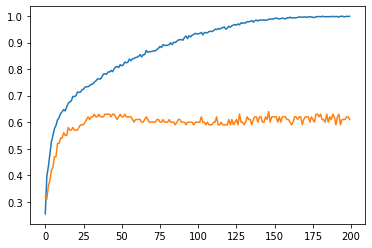

In [ ]:
#Указываем, какие индексы данных во входных векторах брать для обучения
#Делаем это для того, чтобы можно было экспериментировать
#И обучать не на всех колонках данных, а на части
indexes = range(0,37)

#Создаём полносвязанную сеть 
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
#В конце количество нейронов равно количеству классов и softmax
model.add(Dense(len(genres), activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

##Проверка раздельно по трём блокам параметризации

*Разбор данного раздела:* https://youtu.be/8uBvaTGCR5I?t=801

Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.3835 - accuracy: 0.1178 - val_loss: 2.1967 - val_accuracy: 0.1800
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0865 - accuracy: 0.2522 - val_loss: 1.9948 - val_accuracy: 0.2500
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9020 - accuracy: 0.3356 - val_loss: 1.8794 - val_accuracy: 0.3000
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7849 - accuracy: 0.3667 - val_loss: 1.7978 - val_accuracy: 0.3100
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7025 - accuracy: 0.3800 - val_loss: 1.7367 - val_accuracy: 0.3400
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6396 - accuracy: 0.3989 - val_loss: 1.6860 - val_accuracy: 0.3900
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.5883 - accuracy: 0.4189 - val_loss: 1.6492 - val_accuracy: 0.3900
Epoch 8/120
4

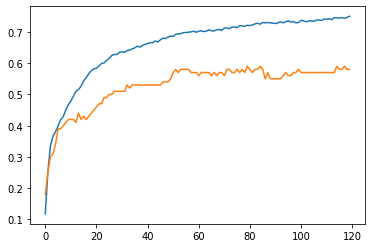

In [ ]:
#Выбираем все виды параметризации
indexes = range(0,37)
#создаем сеть
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
#компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.2649 - accuracy: 0.1489 - val_loss: 2.2351 - val_accuracy: 0.1000
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1774 - accuracy: 0.1967 - val_loss: 2.1663 - val_accuracy: 0.0800
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1097 - accuracy: 0.2189 - val_loss: 2.1171 - val_accuracy: 0.1600
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0579 - accuracy: 0.2567 - val_loss: 2.0796 - val_accuracy: 0.2000
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0169 - accuracy: 0.2789 - val_loss: 2.0501 - val_accuracy: 0.2200
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9842 - accuracy: 0.2967 - val_loss: 2.0279 - val_accuracy: 0.2300
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9571 - accuracy: 0.3122 - val_loss: 2.0079 - val_accuracy: 0.2400
Epoch 8/120
4

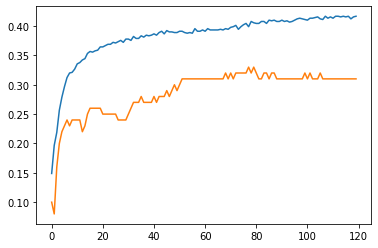

In [ ]:
#Выбираем все параметризации, кроме Мел коэффициентов и частоты цветности
indexes = range(0,5)
#создаем полносвязанную сеть
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
#компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем сеть
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
#выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.2321 - accuracy: 0.1833 - val_loss: 2.1826 - val_accuracy: 0.2000
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0677 - accuracy: 0.3044 - val_loss: 2.0654 - val_accuracy: 0.2800
Epoch 3/120
45/45 [==============================] - 0s 7ms/step - loss: 1.9561 - accuracy: 0.3522 - val_loss: 1.9830 - val_accuracy: 0.3100
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8763 - accuracy: 0.3667 - val_loss: 1.9223 - val_accuracy: 0.3000
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8156 - accuracy: 0.3778 - val_loss: 1.8749 - val_accuracy: 0.3000
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7659 - accuracy: 0.3856 - val_loss: 1.8378 - val_accuracy: 0.3300
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7233 - accuracy: 0.3889 - val_loss: 1.8075 - val_accuracy: 0.3500
Epoch 8/120
4

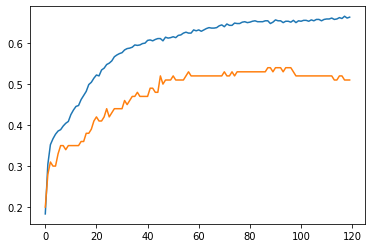

In [ ]:
#Выбираем только Мел коэффициенты
indexes = range(5,25)
#создаем полносвязанную сеть
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
#компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем сеть
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
#выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.2957 - accuracy: 0.1244 - val_loss: 2.2464 - val_accuracy: 0.1500
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1739 - accuracy: 0.1978 - val_loss: 2.1836 - val_accuracy: 0.1700
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0892 - accuracy: 0.2322 - val_loss: 2.1443 - val_accuracy: 0.1700
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0304 - accuracy: 0.2544 - val_loss: 2.1238 - val_accuracy: 0.1800
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9862 - accuracy: 0.2589 - val_loss: 2.1004 - val_accuracy: 0.1700
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9530 - accuracy: 0.2644 - val_loss: 2.0866 - val_accuracy: 0.1800
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9263 - accuracy: 0.2711 - val_loss: 2.0791 - val_accuracy: 0.1800
Epoch 8/120
4

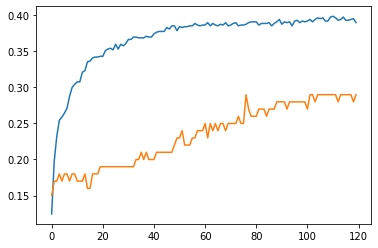

In [ ]:
#Выбираем только Частоту цветности
indexes = range(25,37)
#создаем полносвязанную сеть
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
#компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем сеть
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
#выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.3839 - accuracy: 0.1789 - val_loss: 2.2960 - val_accuracy: 0.2300
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1439 - accuracy: 0.2878 - val_loss: 2.1370 - val_accuracy: 0.2400
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9833 - accuracy: 0.3367 - val_loss: 2.0287 - val_accuracy: 0.3000
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8697 - accuracy: 0.3578 - val_loss: 1.9459 - val_accuracy: 0.2900
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7830 - accuracy: 0.3744 - val_loss: 1.8725 - val_accuracy: 0.3000
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7130 - accuracy: 0.3911 - val_loss: 1.8189 - val_accuracy: 0.2900
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6551 - accuracy: 0.4033 - val_loss: 1.7721 - val_accuracy: 0.2900
Epoch 8/120
4

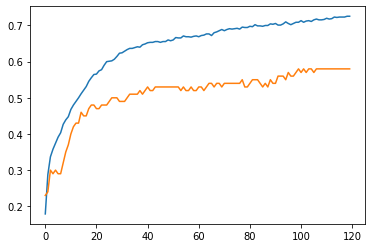

In [ ]:
#Выбираем Мел спектральные коэффициенты и частоты цветности
indexes = range(5,37)
#создаем полносвязанную сеть
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
#компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем сеть
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
#выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.2668 - accuracy: 0.1978 - val_loss: 2.1720 - val_accuracy: 0.2800
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0710 - accuracy: 0.3033 - val_loss: 2.0335 - val_accuracy: 0.2400
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9413 - accuracy: 0.3233 - val_loss: 1.9374 - val_accuracy: 0.2300
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8492 - accuracy: 0.3378 - val_loss: 1.8659 - val_accuracy: 0.2400
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7787 - accuracy: 0.3556 - val_loss: 1.8090 - val_accuracy: 0.2500
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7208 - accuracy: 0.3733 - val_loss: 1.7670 - val_accuracy: 0.2800
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6731 - accuracy: 0.3822 - val_loss: 1.7262 - val_accuracy: 0.2900
Epoch 8/120
4

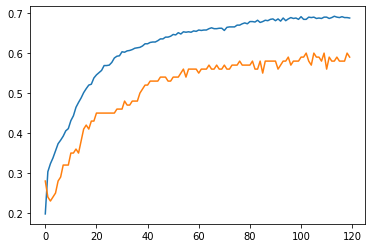

In [ ]:
#Выбираем все параметризации, кроме частоты цветности
indexes = range(0,25)
#создаем сеть
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
#компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем сеть
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
#выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.3584 - accuracy: 0.1333 - val_loss: 2.3283 - val_accuracy: 0.0900
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1724 - accuracy: 0.2056 - val_loss: 2.1939 - val_accuracy: 0.1700
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0392 - accuracy: 0.2856 - val_loss: 2.0990 - val_accuracy: 0.2100
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9437 - accuracy: 0.3144 - val_loss: 2.0298 - val_accuracy: 0.2400
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8707 - accuracy: 0.3311 - val_loss: 1.9710 - val_accuracy: 0.2500
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8130 - accuracy: 0.3311 - val_loss: 1.9260 - val_accuracy: 0.2400
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7650 - accuracy: 0.3389 - val_loss: 1.8885 - val_accuracy: 0.2500
Epoch 8/120
4

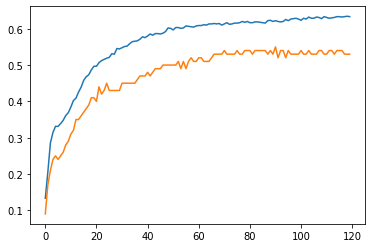

In [ ]:
#Выбираем все параметризации с шагом в 2
indexes = range(0,37,2)
# создаем сеть
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
# компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# обучаем сеть
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Преобразуем данные и добавим их в обучающую и проверочную выборки

In [ ]:
#квадрат значений
X_train_sqr = np.array([[t**2 for t in x] for x in X_train])
X_test_sqr = np.array([[t**2 for t in x] for x in X_test])
#квадратный корнь из абсолютных значений 
X_train_sqrt = np.array([[abs(t)**0.5 for t in x] for x in X_train])
X_test_sqrt = np.array([[abs(t)**0.5 for t in x] for x in X_test])
#1/t
X_train_inv = np.array([[t**(-1) for t in x] for x in X_train])
X_test_inv = np.array([[t**(-1) for t in x] for x in X_test])
#2 в степени t
X_train_exp = np.array([[2**t for t in x] for x in X_train])
X_test_exp = np.array([[2**t for t in x] for x in X_test])
#объединяем все массивы(Функция hstack() соединяет массивы по горизонтали)
X_train_2 = np.hstack([X_train, X_train_sqr, X_train_sqrt, X_train_inv, X_train_exp])
X_test_2 = np.hstack([X_test, X_test_sqr, X_test_sqrt, X_test_inv, X_test_exp])

print(X_train_2.shape)
print(X_test_2.shape)

(900, 185)
(100, 185)


In [ ]:
print(X_train_2[0])# посмотрим первое значение

[ 0.4378592   1.25386373  0.92330374  0.96986636  0.87643491  0.90892995
 -1.38546336  0.11999269 -0.28053483  0.47478213  0.14476229  0.93065756
 -0.78765748  0.79812248 -0.65940964  0.80420604 -0.52324948  0.85813162
 -0.38885614  0.42207487 -0.80410072  1.05137878 -0.22001854  0.76963381
  1.01173289  0.4408222   1.07001958 -0.27068991 -0.25440925  0.47590966
  0.34019398  0.51064344 -0.33200463  0.80792098  1.379044    0.38483946
  0.9010044   0.19172068  1.57217424  0.8524898   0.94064076  0.76813816
  0.82615365  1.91950873  0.01439825  0.07869979  0.22541807  0.02095612
  0.8661235   0.62040431  0.63699949  0.43482107  0.64674735  0.27379002
  0.73638988  0.15120909  0.17814719  0.64657797  1.10539734  0.04840816
  0.5923362   1.02360344  0.19432421  1.1449419   0.07327303  0.06472406
  0.22649001  0.11573194  0.26075672  0.11022708  0.65273631  1.90176236
  0.14810141  0.81180894  0.6617093   1.11976057  0.96088695  0.98481793
  0.93618103  0.95337818  1.17705708  0.34639962  0

Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 16.6642 - accuracy: 0.1389 - val_loss: 23.9764 - val_accuracy: 0.1500
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 14.5779 - accuracy: 0.1578 - val_loss: 20.8661 - val_accuracy: 0.1500
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 12.7981 - accuracy: 0.1833 - val_loss: 18.8212 - val_accuracy: 0.1500
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 11.2403 - accuracy: 0.2144 - val_loss: 16.6583 - val_accuracy: 0.1800
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 9.9131 - accuracy: 0.2411 - val_loss: 14.6591 - val_accuracy: 0.2000
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 8.7810 - accuracy: 0.2722 - val_loss: 13.4536 - val_accuracy: 0.2400
Epoch 7/120
45/45 [==============================] - 0s 3ms/step - loss: 7.8058 - accuracy: 0.2944 - val_loss: 12.1750 - val_accuracy: 0.2300
Ep

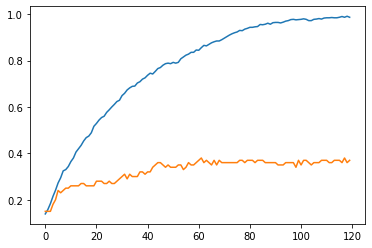

In [ ]:
#создаем сеть
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(X_train_2.shape[1],)))
model.add(Dense(10, activation='softmax'))
# компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем
history = model.fit(X_train_2,
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test_2, y_test))
#выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

## Архитектуры с softmax

*Разбор данного раздела:* https://youtu.be/8uBvaTGCR5I?t=1320

Epoch 1/600
45/45 [==============================] - 0s 4ms/step - loss: 2.4328 - accuracy: 0.1044 - val_loss: 2.3870 - val_accuracy: 0.1000
Epoch 2/600
45/45 [==============================] - 0s 2ms/step - loss: 2.3826 - accuracy: 0.1144 - val_loss: 2.3339 - val_accuracy: 0.1100
Epoch 3/600
45/45 [==============================] - 0s 2ms/step - loss: 2.3406 - accuracy: 0.1244 - val_loss: 2.2922 - val_accuracy: 0.1200
Epoch 4/600
45/45 [==============================] - 0s 2ms/step - loss: 2.3054 - accuracy: 0.1400 - val_loss: 2.2556 - val_accuracy: 0.1300
Epoch 5/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2741 - accuracy: 0.1656 - val_loss: 2.2249 - val_accuracy: 0.1800
Epoch 6/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2461 - accuracy: 0.1856 - val_loss: 2.1967 - val_accuracy: 0.1800
Epoch 7/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2203 - accuracy: 0.1944 - val_loss: 2.1715 - val_accuracy: 0.1900
Epoch 8/600
4

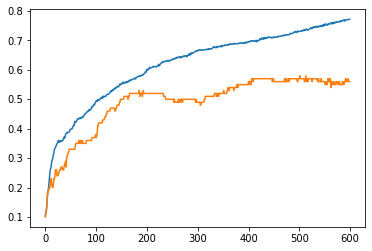

In [ ]:
#создадим сеть с разными ветками и активациями
input1 = Input((37,)) #создадим входной слой
#создадим первую ветку с elu
x1 = Dense(10, activation="elu")(input1) 
x1 = Dense(10, activation="elu")(x1)
#создадим вторую ветку с softmaх
x2 = Dense(10, activation="elu")(input1)
x2 = Dense(40, activation="softmax")(x2)
#объединяем ветки
x = concatenate([x1, x2])

x = Dense(10, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)
#компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем
history = model.fit(X_train,
                    y_train,
                    epochs=600,
                    batch_size=20,
                    validation_data=(X_test, y_test))
#выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6614 - accuracy: 0.7722 - val_loss: 1.3453 - val_accuracy: 0.5600
Epoch 2/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6604 - accuracy: 0.7722 - val_loss: 1.3458 - val_accuracy: 0.5700
Epoch 3/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6598 - accuracy: 0.7711 - val_loss: 1.3467 - val_accuracy: 0.5600
Epoch 4/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6592 - accuracy: 0.7722 - val_loss: 1.3472 - val_accuracy: 0.5600
Epoch 5/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6579 - accuracy: 0.7711 - val_loss: 1.3470 - val_accuracy: 0.5600
Epoch 6/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6574 - accuracy: 0.7733 - val_loss: 1.3481 - val_accuracy: 0.5700
Epoch 7/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6565 - accuracy: 0.7722 - val_loss: 1.3468 - val_accuracy: 0.5700
Epoch 8/600
4

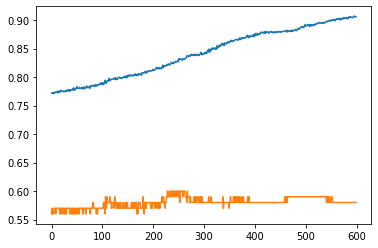

In [ ]:
#дообучим сеть
history = model.fit(X_train,
                    y_train,
                    epochs=600,
                    batch_size=20,
                    validation_data=(X_test, y_test))
#выведим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/600
45/45 [==============================] - 0s 4ms/step - loss: 2.3949 - accuracy: 0.0911 - val_loss: 2.3586 - val_accuracy: 0.1100
Epoch 2/600
45/45 [==============================] - 0s 2ms/step - loss: 2.3472 - accuracy: 0.1078 - val_loss: 2.3243 - val_accuracy: 0.1200
Epoch 3/600
45/45 [==============================] - 0s 2ms/step - loss: 2.3050 - accuracy: 0.1267 - val_loss: 2.2940 - val_accuracy: 0.1200
Epoch 4/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2674 - accuracy: 0.1478 - val_loss: 2.2674 - val_accuracy: 0.1700
Epoch 5/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2337 - accuracy: 0.1656 - val_loss: 2.2432 - val_accuracy: 0.1700
Epoch 6/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2027 - accuracy: 0.1911 - val_loss: 2.2219 - val_accuracy: 0.2000
Epoch 7/600
45/45 [==============================] - 0s 2ms/step - loss: 2.1750 - accuracy: 0.2067 - val_loss: 2.2026 - val_accuracy: 0.2100
Epoch 8/600
4

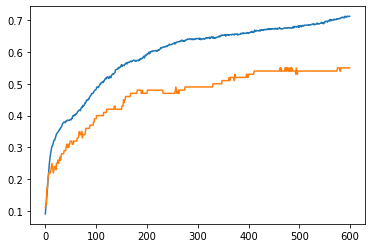

In [ ]:
#Создадим сеть
input1 = Input((37,))

x1 = Dense(10, activation="elu")(input1)
x1 = Dense(10, activation="elu")(x1)

x = Dense(10, activation='elu')(x1)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)
#компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем
history = model.fit(X_train,
                    y_train,
                    epochs=600,
                    batch_size=20,
                    validation_data=(X_test, y_test))
#выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/1000
45/45 [==============================] - 0s 7ms/step - loss: 2.2384 - accuracy: 0.1889 - val_loss: 2.1444 - val_accuracy: 0.3300
Epoch 2/1000
45/45 [==============================] - 0s 4ms/step - loss: 2.0210 - accuracy: 0.3278 - val_loss: 2.0011 - val_accuracy: 0.3000
Epoch 3/1000
45/45 [==============================] - 0s 4ms/step - loss: 1.8649 - accuracy: 0.3567 - val_loss: 1.9001 - val_accuracy: 0.3200
Epoch 4/1000
45/45 [==============================] - 0s 4ms/step - loss: 1.7500 - accuracy: 0.3767 - val_loss: 1.8307 - val_accuracy: 0.3000
Epoch 5/1000
45/45 [==============================] - 0s 4ms/step - loss: 1.6669 - accuracy: 0.3822 - val_loss: 1.7788 - val_accuracy: 0.3100
Epoch 6/1000
45/45 [==============================] - 0s 4ms/step - loss: 1.6034 - accuracy: 0.3944 - val_loss: 1.7294 - val_accuracy: 0.3400
Epoch 7/1000
45/45 [==============================] - 0s 4ms/step - loss: 1.5499 - accuracy: 0.4133 - val_loss: 1.6846 - val_accuracy: 0.3600
Epoch 

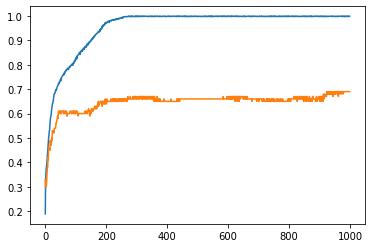

In [ ]:
indexes = range(0,37)
#создадим сеть с 7 верками, с разным количеством нейронов и функциями активации
input1 = Input((len(indexes),))

x1 = Dense(64, activation="elu")(input1)
x1 = Dense(64, activation="elu")(x1)

x2 = Dense(64, activation="elu")(input1)
x2 = Dense(40, activation="softmax")(x2)

x3 = Dense(64, activation="elu")(input1)
x3 = Dense(200, activation="softmax")(x3)

x4 = Dense(40, activation="softmax")(input1)

x5 = Dense(200, activation="softmax")(input1)

x6 = Dense(10, activation="softmax")(input1)

x7 = Dense(64, activation="elu")(input1)
x7 = Dense(10, activation="softmax")(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(64, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)
#компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=1000,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
#выводим график функции
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/400
45/45 [==============================] - 1s 17ms/step - loss: 1.8119 - accuracy: 0.3711 - val_loss: 1.9414 - val_accuracy: 0.3700
Epoch 2/400
45/45 [==============================] - 0s 10ms/step - loss: 1.2660 - accuracy: 0.5633 - val_loss: 1.8407 - val_accuracy: 0.3800
Epoch 3/400
45/45 [==============================] - 0s 11ms/step - loss: 1.0853 - accuracy: 0.6278 - val_loss: 1.7255 - val_accuracy: 0.4400
Epoch 4/400
45/45 [==============================] - 0s 10ms/step - loss: 0.9724 - accuracy: 0.6733 - val_loss: 1.6409 - val_accuracy: 0.4600
Epoch 5/400
45/45 [==============================] - 0s 10ms/step - loss: 0.8938 - accuracy: 0.7011 - val_loss: 1.5772 - val_accuracy: 0.4300
Epoch 6/400
45/45 [==============================] - 0s 11ms/step - loss: 0.8115 - accuracy: 0.7367 - val_loss: 1.4953 - val_accuracy: 0.4500
Epoch 7/400
45/45 [==============================] - 0s 10ms/step - loss: 0.7558 - accuracy: 0.7567 - val_loss: 1.4288 - val_accuracy: 0.5100
Epoch 

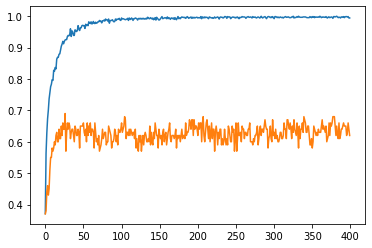

In [ ]:
indexes = range(0,37)
#поменяем количество нейронов в слоях и добавим нормальзацию после кажного слоя
input1 = Input((len(indexes),))

x1 = Dense(256, activation="elu")(input1)
x1 = BatchNormalization()(x1)
x1 = Dense(256, activation="elu")(x1)
x1 = BatchNormalization()(x1)

x2 = Dense(256, activation="elu")(input1)
x2 = BatchNormalization()(x2)
x2 = Dense(40, activation="softmax")(x2)
x2 = BatchNormalization()(x2)

x3 = Dense(256, activation="elu")(input1)
x3 = BatchNormalization()(x3)
x3 = Dense(200, activation="softmax")(x3)
x3 = BatchNormalization()(x3)

x4 = Dense(40, activation="softmax")(input1)
x4 = BatchNormalization()(x4)

x5 = Dense(200, activation="softmax")(input1)
x5 = BatchNormalization()(x5)

x6 = Dense(10, activation="softmax")(input1)
x6 = BatchNormalization()(x6)

x7 = Dense(256, activation="elu")(input1)
x7 = BatchNormalization()(x7)
x7 = Dense(10, activation="softmax")(x7)
x7 = BatchNormalization()(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = BatchNormalization()(x)
x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)
#компилируем
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=400,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
#выводим гарфик обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

## Распознавание выбранной песни

*Разбор данного раздела:* https://youtu.be/8uBvaTGCR5I?t=1947


In [ ]:
#Выбираем песню для распознавания
songname = './genres/rock/rock.00000.au'
#Получаем аудио сигнал
y, sr = librosa.load(songname, mono=True, duration=30)
#Параметризуем сигнал
out = get_features(y, sr)

In [ ]:
#Добавляем ону размерность, этого требует model.predict
out = np.array(out).reshape(1,37)

In [ ]:
#Проверяем размерность
out.shape

(1, 37)

In [ ]:
#Делаем преобразование
#С помощью scaler, обученного на обучающей выборке
out = scaler.transform(out)

In [ ]:
#Выводим нормированный вектор
print(out)

[[-0.02690168 -0.28780161 -0.27660395 -0.21895271 -0.32147562  0.2781953
   0.31028482 -0.65605257  0.26401823 -0.87942113  0.71996303 -1.03300635
   0.47878823 -0.78838959  0.62573777 -0.71319511  0.60099535 -1.09968739
   0.08155267 -0.4773205   0.18880677 -0.87535319  0.40799876 -0.01668224
  -0.11444064 -0.07569812  1.12639628  0.89248677  0.40919863  0.74039905
  -0.40429019 -0.66451179 -0.58669354  0.08835712  0.88386322 -0.76529203
  -0.85039474]]


In [ ]:
#Делаем predict
y = model.predict(out)

In [ ]:
#Выводим выход с softmax
print(y)
#И распознанный класс
print(np.argmax(y))
#Проверяем правильный индекс исходного жанра
print(genres.index("rock"))

[[3.4067153e-08 2.1341413e-05 2.6615015e-07 4.3810080e-05 2.8463668e-07
  3.2585165e-10 8.7570578e-07 3.2923836e-06 2.7556430e-09 9.9993014e-01]]
9
9
